In [ ]:
#Install Library Obspy (Analisis Data Seismogram)

!pip install obspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
#Import Library

import os
import obspy
from obspy import read, UTCDateTime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta
from obspy.signal.filter import envelope
from scipy.stats import kurtosis, skew
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
#Function Parameter Input Model

def runningKurt(x, N):
    y = np.zeros((len(x) - (N - 1),))
    for i in range(len(x) - (N - 1)):
         y[i] = kurtosis(x[i:(i + N)])
    return y

def runningSkew(x, N):
    y = np.zeros((len(x) - (N - 1),))
    for i in range(len(x) - (N - 1)):
         y[i] = skew(x[i:(i + N)])
    return y

def preprocess_non_filter(stream):
  for i in range(len(stream)):
    stream[i] = stream[i].normalize()
  return stream

def preprocess_filter(stream, freq, corners):
  for i in range(len(stream)):
    stream[i] = stream[i].filter('lowpass', freq=freq, corners=corners, zerophase=True).normalize()
  return stream

def preprocess_filter_bandpass(stream, freq1, freq2, corners):
  for i in range(len(stream)):
    stream[i] = stream[i].filter('bandpass', freqmin=freq1, freqmax=freq2, corners=corners, zerophase=True).normalize()
  return stream

def make_parameters(stream, sta, lta, sampling_rate):
  traces_classic_sta_lta = classic_sta_lta(stream[0], int(sta*sampling_rate), int(lta*sampling_rate))
  traces_recursive_sta_lta = recursive_sta_lta(stream[0], int(sta*sampling_rate), int(lta*sampling_rate))
  traces_envelope = envelope(stream[0].data)
  traces_kurtosis = list(runningKurt(stream[0].data, 360))
  traces_kurtosis[:0] = [0 for i in range(len(traces_kurtosis), len(stream[0].data), 1)]
  traces_skewness = list(runningSkew(stream[0].data, 360))
  traces_skewness[:0] = [0 for i in range(len(traces_skewness), len(stream[0].data), 1)]

  return traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness

In [ ]:
#Import Model Deep Learning hasil Training Data

savedModel = tf.keras.models.load_model("/content/model_predict_wave_p_s_teleseismik.h5")
savedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 256)            1280      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 256)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 3, 128)            197120    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0

In [ ]:
#Input Data Seismogram (.mseed / .miniseed / .SAC)

trace_example = read("/content/2021-11-10-mww60-irian-jaya-region-indonesia.miniseed")

#trace_example = trace_example.select(id='II.COCO.10.BHZ')    #Pemilihan Stasiun (Jika event memiliki data lebih dari 1 stasiun)

print(trace_example)

plt.figure(figsize=(20,5))
plt.plot(trace_example[0], label='Trace Example', color='black')
plt.legend()
plt.show()

TypeError: ignored

In [ ]:
#Proses Prediksi event Seismogram

trace_example = preprocess_filter(trace_example, 1, 3)    #Memulai pre-processing (filtering & normalized), param 2 (nilai lowpass filternya, param 3 (ordernya))
#trace_example = preprocess_filter_bandpass(trace_example, 0.1, 10, 3)    #Memulai pre-processing (filtering & normalized), param 2 (nilai lowpass filternya, param 3 (ordernya))

traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness = make_parameters(trace_example, 2, 30, 40)  #Membuat parameter sebagai data test

data_example = {'trace' : trace_example[0].data,                    #Membuat 6 kolom sebagai Features pada Input Model
                'classic STA/LTA' : traces_classic_sta_lta,
                'recursive STA/LTA' : traces_recursive_sta_lta,
                'envelope' : traces_envelope,
                'kurtosis' : traces_kurtosis,
                'skewness' : traces_skewness
                 }

df_example = pd.DataFrame(data_example)     #Data input dibuat dalam DataFrame

predict = savedModel.predict(df_example)    #Proses Prediksi

arr_predict = np.array([pred.argmax() for pred in predict])     #Mengambil nilai index dari hasil Max pada setiap label

763/763 [==============================] - 2s 2ms/step


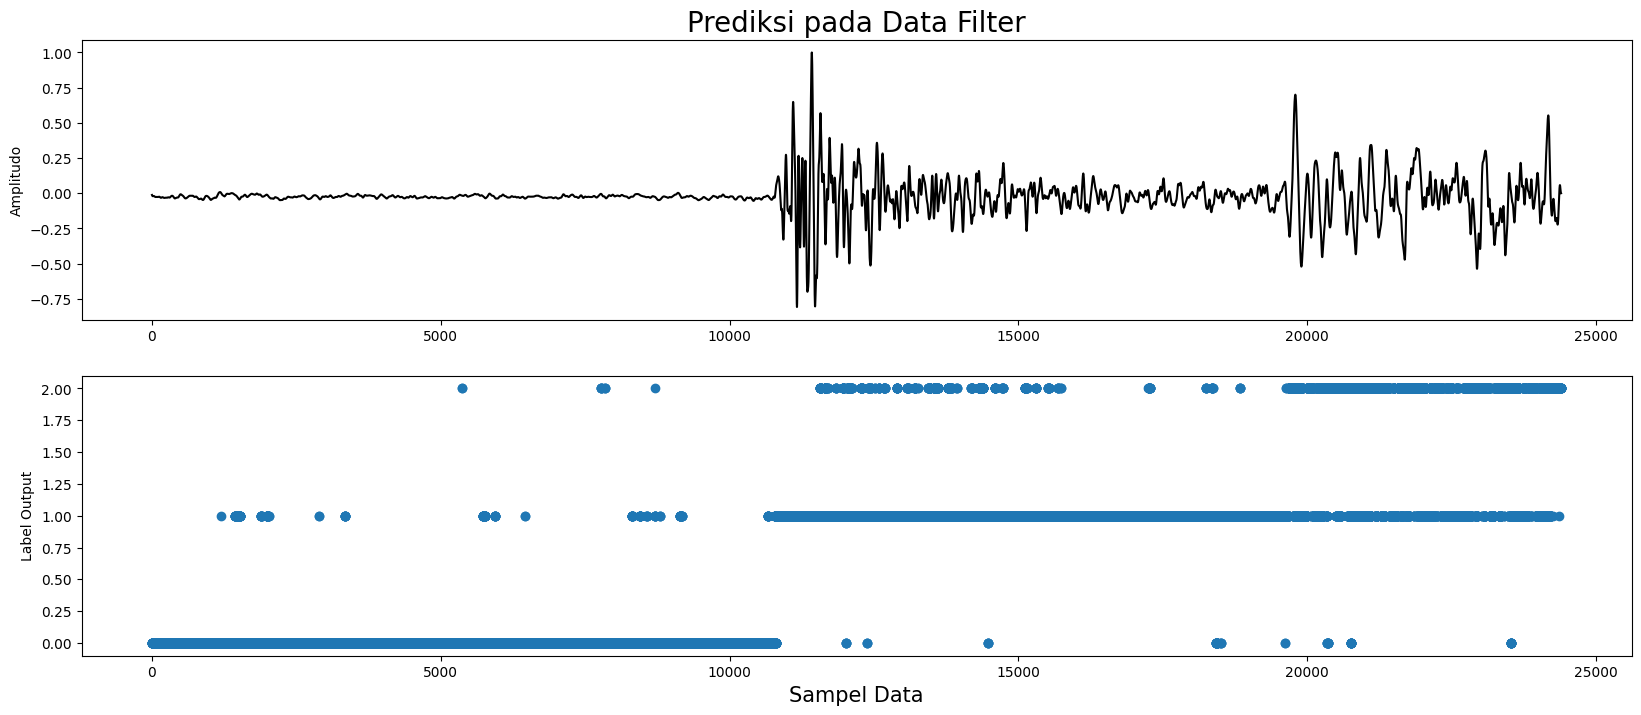

In [ ]:
# Visualisasi Hasil Model Prediksi

plt.figure(figsize=(20,8))
plt.subplot(211)

plt.title("Prediksi pada Data Filter", fontsize=20)
plt.ylabel("Amplitudo")
plt.plot(trace_example[0].data, label='Trace Example', color='black')

'''
plt.axvline(x= 12150, linewidth=1, color='red', linestyle='--', label='Predict P Machine Learning')
plt.axvline(x= 12240, linewidth=1, color='blue', linestyle='--', label='Picked P IRIS Wilber')
plt.axvline(x= 22320, linewidth=1, color='green', linestyle='--', label='Picked S IRIS Wilber')
plt.axvline(x= 22780, linewidth=1, color='brown', linestyle='--', label='Predict S Machine Learning')
plt.legend(loc='upper left')
'''

plt.subplot(212)
plt.xlabel("Sampel Data", fontsize=15)
plt.ylabel("Label Output")
plt.scatter(np.arange(len(trace_example[0].data)),arr_predict, label='Machine Learning Output')

'''
plt.axvline(x= 12150, linewidth=1, color='red', linestyle='--')
plt.axvline(x= 22780, linewidth=1, color='brown', linestyle='--')
plt.legend(loc='upper left')
'''

plt.show()